# SIR Epidemiology model: Outbreak on Tristan de Cunha

This example shows how the [SIRModel](http://pints.readthedocs.io/en/latest/toy/sir_model.html) can be used.

The SIR model describes a disease breaking out in a population split into a susceptible (S), infected (I), and recovered (R) part (see [wikipedia](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model)).

The formulation shown here was used by [Toni et al.](http://rsif.royalsocietypublishing.org/content/6/31/187.short), in a paper in which they also give real data of a common-cold outbreak on the isle of Tristan de Cunha (originally from [Hammond & Tyrrell](https://www.cambridge.org/core/journals/epidemiology-and-infection/article/mathematical-model-of-commoncold-epidemics-on-tristan-da-cunha/787670BB798E292A9AFE59B6B51DE57A) and [Shibli et al.](https://www.cambridge.org/core/journals/epidemiology-and-infection/article/common-colds-on-tristan-da-cunha/D83E74AB677CCBC74E71A319EAD6C330)). In this formulation, the susceptible population is unknown, the we can observe the infected and recovered population.

The model has three parameters: infection rate ``gamma``, recovery rate ``v``, and the initial susceptible population ``S0``.



Parameters:
[0.026, 0.285, 38]


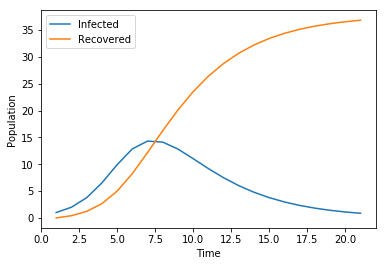

In [5]:
import pints
import pints.toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Create a model
model = pints.toy.SIRModel()

# Run a simulation
parameters = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(parameters, times)

print('Parameters:')
print(parameters)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(times, values)
plt.legend(['Infected', 'Recovered'])
plt.show()

We can have a look at the real data too:

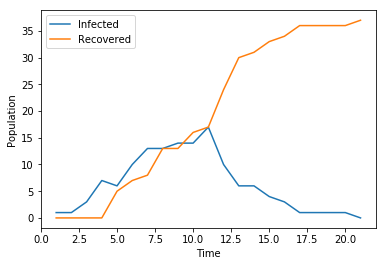

In [6]:
real_values = model.suggested_values()

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(times, real_values)
plt.legend(['Infected', 'Recovered'])
plt.show()

Next, we set up a problem. Because this model has multiple outputs (2), we use a [MultiOutputProblem](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#multi-output-problem).

In [7]:
problem = pints.MultiOutputProblem(model, times, real_values)
score = pints.SumOfSquaresError(problem)

To create a probabilistic model, we'll assume the data can be perfectly described by the model + Gausian noise with an unknown standard deviation `sigma1` in I and `sigma2` in R.

In [8]:
loglikelihood = pints.UnknownNoiseLogLikelihood(problem)

We can now use MCMC to have a guess at the parameters! We'll try to infer two noise parameters at the same time.

In [9]:
# Starting points
x0 = [
    [0.001, 0.20, 52, 3, 3],
    [0.05, 0.34, 34, 3, 3],
    [0.02, 0.18, 20, 3, 3],
]

# Create MCMC routine
mcmc = pints.MCMCSampling(loglikelihood, 3, x0)
mcmc.set_max_iterations(3000)
mcmc.set_log_to_screen(False)
chains = mcmc.run()

/home/michael/dev/pints/pints/_log_likelihoods.py:155: RuntimeWarning: invalid value encountered in log
  - np.sum(error**2, axis=0) / (2 * sigma**2))


We now have a quick look at the traces, to get an indication of how well the chains have converged:

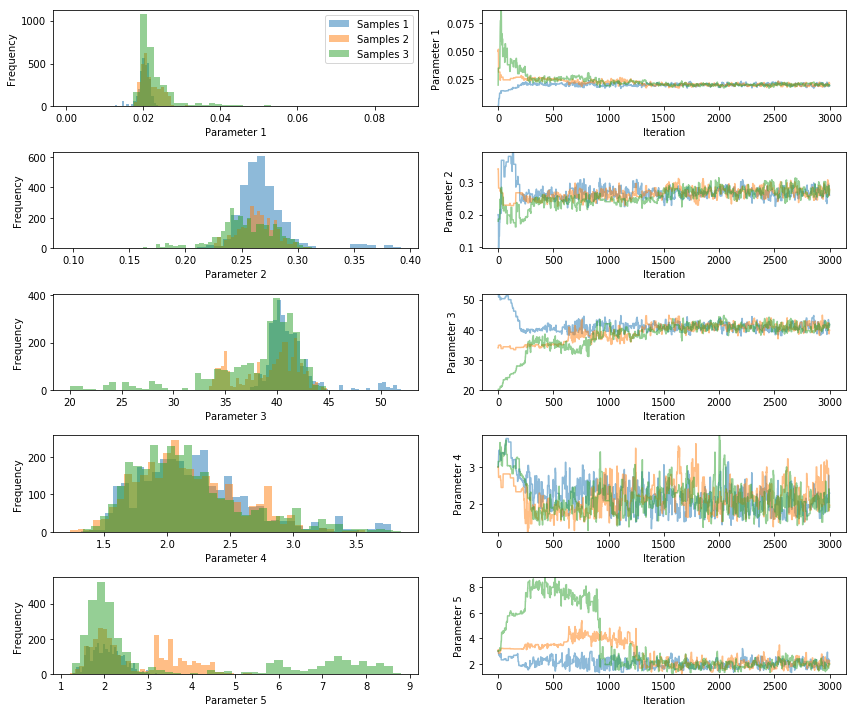

In [10]:
plt.figure()
pints.plot.trace(chains)
plt.show()

Finally, we compare some predictions based on the final samples to the real data:

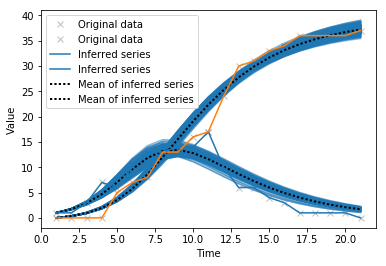

In [11]:
samples = chains[0, -1000:]

plt.figure()
ax = pints.plot.series(samples, problem)
plt.plot(times, real_values)
plt.show()